------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#
class RBFnn:
    def __init__(self, input_size, neuron_num, output_size):
        self.L = output_size
        self.N = input_size
        self.M = neuron_num
        self.mu = np.ones([input_size, neuron_num])
        self.sigma = np.ones([input_size, neuron_num])
        self.W = np.ones([neuron_num, output_size])
        self.bias = np.zeros([1, output_size])#*0
    # def center_init(self, x):
    #     kmeans = KMeans(n_clusters=self.M, random_state=0, n_init="auto").fit(x)
    #     self.mu = kmeans.cluster_centers_.T
    def forward(self, x):
        phi = np.exp(-((np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0))**2)
        phi = phi.prod(1)
        self.phi = phi
        y_hat = phi @ self.W + self.bias
        return(y_hat)
    def grad(self, x, e, Ac):
        
        # Forward
        y_hat = self.forward(x)
        # grad
        error1 = (e @ np.linalg.pinv(Ac) @ np.ones([2,1])) + 0.01*y_hat #y_hat - y
        error = (np.expand_dims(self.W, 0)*np.expand_dims(error1, 1)).sum(-1)  # sample * neuron_num

        grad_W = (np.expand_dims(self.phi,-1)*np.expand_dims(error1, 1)).sum(0)

        grad_mu = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0)**2)*np.expand_dims(error, 1)
        grad_mu = grad_mu.mean(0)

        grad_sigma = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))**2/np.expand_dims(self.sigma,0)**3)*np.expand_dims(error, 1)
        grad_sigma = grad_sigma.mean(0)

        grad_bias = error1.mean(-1).mean(0)#*0
        return(grad_W, grad_mu, grad_sigma, grad_bias)
    def Train(self, x, e, Ac, iteration_num = 1000, learning_rate = 0.01):
        # self.center_init(x)
        for i in range(iteration_num):
            grad_W, grad_mu, grad_sigma, grad_bias = self.grad(x, e, Ac)
            self.W -= learning_rate * grad_W
            self.mu -= learning_rate * grad_mu
            self.sigma -= learning_rate * grad_sigma
            self.bias -= learning_rate * grad_bias
            

In [2]:
import numpy as np

class Pendulum_Nonlinear_System:
    def __init__(self, dt = 0.01):
        self.Ac = -20*np.eye(2)
        self.dt = dt
        self.t = np.linspace(0, 50, int((50-0)/dt))
        self.xd = np.array([[np.sin(self.t),np.cos(self.t)]]).T
        self.x = np.array([[.5],[.5]])
    def step(self, u):
        self.x_dot = np.array([[self.x[1,0]], [-5*self.x[0,0]**3-2*self.x[1,0]+u]])
        self.x += self.x_dot * self.dt


class Van_der_Pol_Oscillator_Nonlinear_System:
    def __init__(self, dt = 0.01):
        self.Ac = -1*np.eye(2)
        self.mu = 1
        self.dt = dt
        self.t = np.linspace(0, 50, int((50-0)/dt))
        self.xd = np.array([[np.sin(.5*self.t)+np.cos(.25*self.t),.5*np.cos(.5*self.t)-.25*np.sin(.25*self.t)]]).T
        self.x = np.array([[.5],[.5]])
    def step(self, u):
        self.x_dot = self.mu * (1-self.x[0,0]**2)*self.x[1,0] - self.x[0,0] + u
        self.x[1] += self.x_dot * self.dt
        self.x[0] += self.x[1] * self.dt

## Van der Pol Oscillator Nonlinear System

In [17]:
rbf = RBFnn(input_size = 4, neuron_num = 4, output_size = 1)
plant = Van_der_Pol_Oscillator_Nonlinear_System()
history = {'x': np.zeros(plant.xd.shape), 'u':[]}
for i in range(len(plant.t)):
    xc = np.concatenate((np.copy(plant.x), plant.xd[i])).T
    e = np.copy(plant.x) - plant.xd[i]

    u = rbf.forward(xc)
    plant.step(u[0,0])
    history['x'][i] = plant.x
    history['u'].append(u[0,0])

    rbf.Train(xc, -e.T, plant.Ac, iteration_num = 1, learning_rate=0.1)


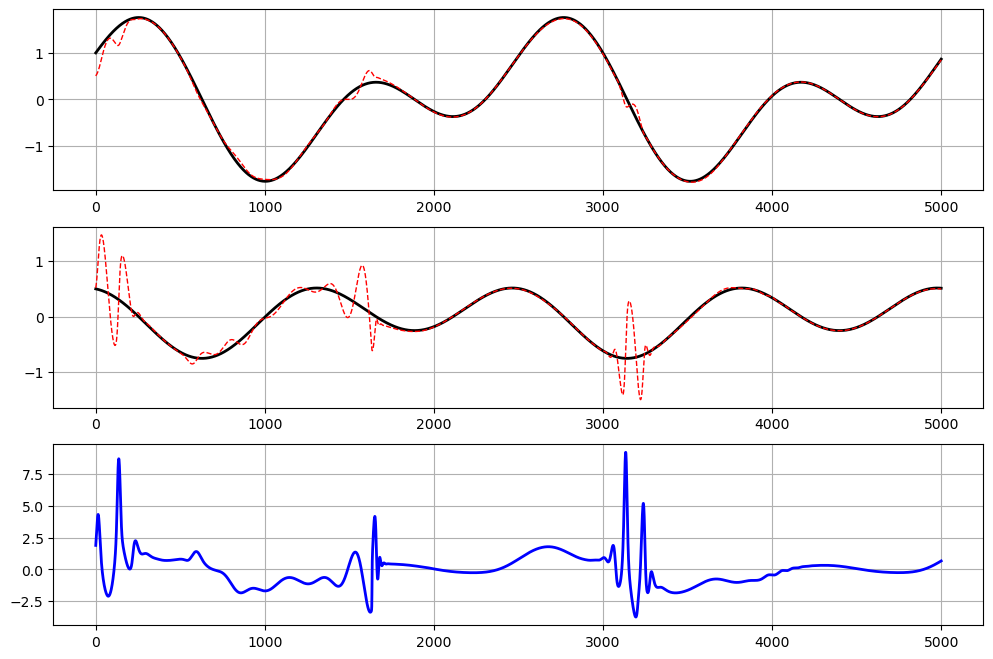

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(plant.xd[:,0,0], 'k-', label='state 1 reference', linewidth = 2)
plt.plot(history['x'][:,0,0], 'r--', label='state 1 tracked', linewidth = 1)
plt.grid('on')
plt.subplot(3,1,2)
plt.plot(plant.xd[:,1,0], 'k-', label='state 2 reference', linewidth = 2)
plt.plot(history['x'][:,1,0], 'r--', label='state 2 tracked', linewidth = 1)
plt.grid('on')

plt.subplot(3,1,3)
plt.plot(history['u'], 'b-', label='control command', linewidth = 2)
plt.grid('on')


##  Pendulum Nonlinear System

In [382]:
rbf = RBFnn(input_size = 4, neuron_num = 2, output_size = 1)
plant = Pendulum_Nonlinear_System()
history = {'x': np.zeros(plant.xd.shape), 'u':[]}
for i in range(len(plant.t)):
    xc = np.concatenate((np.copy(plant.x), plant.xd[i])).T
    e = np.copy(plant.x) - plant.xd[i]

    u = rbf.forward(xc)
    plant.step(u[0,0])
    history['x'][i] = plant.x
    history['u'].append(u[0,0])

    rbf.Train(xc, -e.T, plant.Ac, iteration_num = 1, learning_rate=0.3*10)


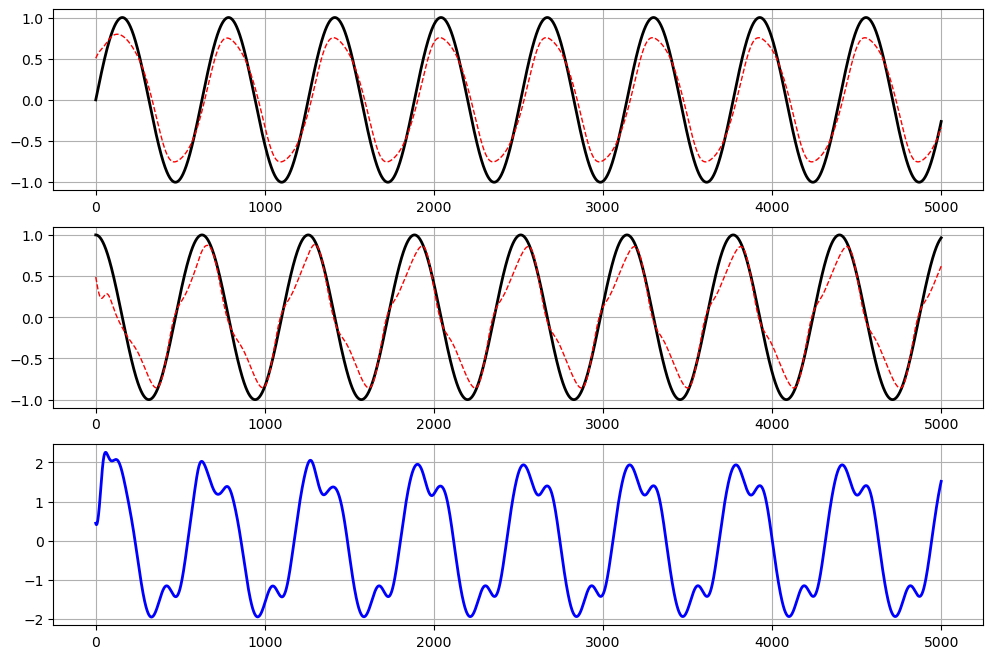

In [383]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(plant.xd[:,0,0], 'k-', label='state 1 reference', linewidth = 2)
plt.plot(history['x'][:,0,0], 'r--', label='state 1 tracked', linewidth = 1)
plt.grid('on')
plt.subplot(3,1,2)
plt.plot(plant.xd[:,1,0], 'k-', label='state 2 reference', linewidth = 2)
plt.plot(history['x'][:,1,0], 'r--', label='state 2 tracked', linewidth = 1)
plt.grid('on')

plt.subplot(3,1,3)
plt.plot(history['u'], 'b-', label='control command', linewidth = 2)
plt.grid('on')
